In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
results_files = [
    'l1-fanout-qtrain',
    'l1-fanout',
    'weightscale',
    'nopenalty'
]

names_translate = {
    'l1-fanout-qtrain': 'SynOp + Quant.',
    'l1-fanout': 'SynOp Loss',
    'weightscale': 'Weight scaling',
    'nopenalty': 'Baseline'
}
    
    
def smooth(series):
    return (series[1:] + series[:-1]) / 2.

def read_results_files(postfix):
    results_folder = './results/'

    
    coefficients = {}
    activities = {}
    accuracies = {}

    for name in results_files:
        f = np.loadtxt(os.path.join(results_folder,
                                    name + postfix + '.txt'))
        f = np.atleast_2d(f)
        coeff, act, acc = f.T
        print(f.T.shape)
        idx = np.argsort(coeff)
        coefficients[names_translate[name]] = coeff[idx]
        activities[names_translate[name]] = act[idx]
        accuracies[names_translate[name]] = acc[idx]
    
    return coefficients, activities, accuracies


def smooth(y):
    box = [0.05, 0.2, 0.5, 0.2, 0.05]
    
    y_smooth = np.convolve(y, box, mode='same')
    y_smooth = y_smooth[1:-2]
    return y_smooth

os.makedirs("figures", exist_ok=True)

## Testing the quantized network

(3, 34)
(3, 33)
(3, 18)
(3, 1)


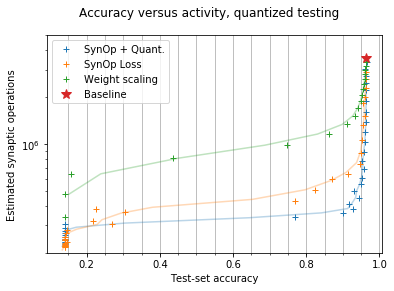

In [3]:
coefficients, activities, accuracies = read_results_files('_qtest_True')

plt.figure(figsize=(6, 4))
ax = plt.gca()
for i, name in enumerate(coefficients.keys()): 
    if name == 'Baseline': continue
    # First plot
    ax.plot(accuracies[name], activities[name], '+', label=name)
    # Second plot
    act, acc = smooth(activities[name]), smooth(accuracies[name])
    ax.plot(acc, act, alpha=0.3, c=f'C{i}')
    
# Plot nopenalty (single point)
ax.plot(accuracies['Baseline'], activities['Baseline'],
           '*', label='Baseline', c='C3', markersize=10)

    
ax.set_yscale('log')
ax.set_ylim([2e5, 5e6])
ax.legend(loc=0)
ax.set_xlabel("Test-set accuracy")
ax.set_ylabel("Estimated synaptic operations")
ax.set_xticks(np.arange(0.15, 1.01, 0.05), minor=True)
ax.grid(axis='x', which='minor')

# fig.tight_layout()
plt.suptitle("Accuracy versus activity, quantized testing");
plt.savefig("figures/act-acc.pdf", bbox_inches='tight')

coeff_qtrain, act_qtrain, acc_qtrain = coefficients, activities, accuracies

### Analyzing the dependence on α

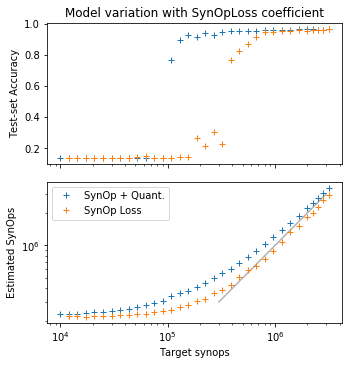

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(5,5), sharex=True)
ax[1].plot([3e5, 3e6], [3e5, 3e6], 'k', alpha=0.3)

for name in ['SynOp + Quant.', 'SynOp Loss']:  # ignore weight scaling and nopenalty
    ax[1].plot(coefficients[name], activities[name], '+', label=name)
    ax[0].plot(coefficients[name], accuracies[name], '+')


ax[1].set_yscale('log')
ax[1].set_ylabel('Estimated SynOps')
ax[1].set_xlabel('Target synops')
ax[0].set_ylabel('Test-set Accuracy')
ax[0].set_xscale('log')
ax[1].legend()

fig.tight_layout()
ax[0].set_title("Model variation with SynOpLoss coefficient")

fig.savefig("figures/alpha.pdf", bbox_inches='tight')

## Testing the non-quantized network

## Testing the spiking (Sinabs) network

(3, 34)
(3, 33)
(3, 18)
(3, 1)


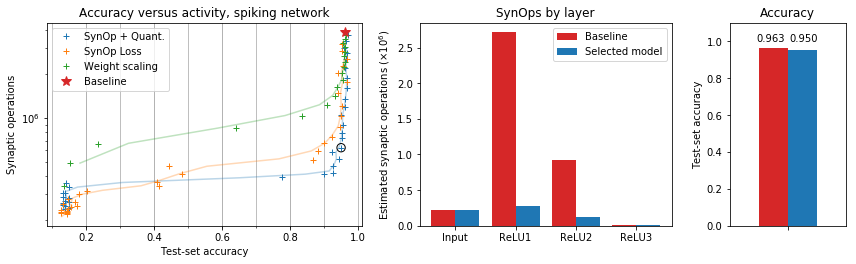

In [6]:
coefficients, activities, accuracies = read_results_files('_spiking_nothr')

fig, ax = plt.subplots(1, 3, figsize=(12, 3.6), gridspec_kw={'width_ratios': [1, .8, 0.37]})
for i, name in enumerate(coefficients.keys()):  # exclude nopenalty
    if name == 'Baseline': continue
    # First plot
    ax[0].plot(accuracies[name], activities[name], '+',
             label=name.split('_qtest_True')[0])
    acc, act = smooth(accuracies[name]), smooth(activities[name])
    ax[0].plot(acc, act, alpha=0.3 , c=f'C{i}')
    
# Plot nopenalty (single point)
ax[0].plot(accuracies['Baseline'], activities['Baseline'],
        '*', label='Baseline', c='C3', markersize=10)
    
ax[0].set_yscale('log')
# ax[0].set_ylim([1e3, 1e7])
ax[0].legend(loc=0)
ax[0].set_xlabel("Test-set accuracy")
ax[0].set_ylabel("Synaptic operations")

ax[0].set_xticks(np.arange(0.1, 1, 0.1), minor=True)
ax[0].grid(axis='x', which='both')

ax[0].scatter(0.951, 625554 , facecolor='none', edgecolor='k', s=70, zorder=10)


# plot layer by layer comparison
f = np.load('opt_benchmark.npz')

layers = ['Input', 'ReLU1', 'ReLU2', 'ReLU3']

xticks = np.arange(len(layers))
ax[1].bar(xticks - 0.2, f['baseline_activity'] / 1e6, width=0.4, align='center',
          label="Baseline", color='C3')
ax[1].bar(xticks + 0.2, f['optimized_activity'] / 1e6, width=0.4,
          align='center', label=r"Selected model", color='C0')
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(layers)
ax[1].set_ylabel(r"Estimated synaptic operations ($\times 10^6$)")
ax[1].legend(loc="upper right")

ax[2].bar([-0.2], f['baseline_accuracy'], color='C3', width=0.4, align='center')
ax[2].bar([+0.2], f['optimized_accuracy'], color='C0', width=0.4, align='center')
ax[2].set_xticks([0])
ax[2].set_xticklabels([''])
ax[2].set_xlim([-.8, .8])
ax[2].set_ylim([0, 1.1])
ax[2].text(-.23, 1.0, f"{f['baseline_accuracy']:.3f}", horizontalalignment='center')
ax[2].text(.22, 1.0, f"{f['optimized_accuracy']:.3f}", horizontalalignment='center')
ax[2].set_ylabel('Test-set accuracy')

fig.tight_layout()
ax[0].set_title("Accuracy versus activity, spiking network");
ax[1].set_title("SynOps by layer")
ax[2].set_title("Accuracy")
fig.savefig("figures/act-acc_sinabs.pdf", bbox_inches='tight')

coeff_sinabs, act_sinabs, acc_sinabs = coefficients, activities, accuracies

Text(0.5, 0.98, 'Comparison between quantized ANN and Sinabs tests')

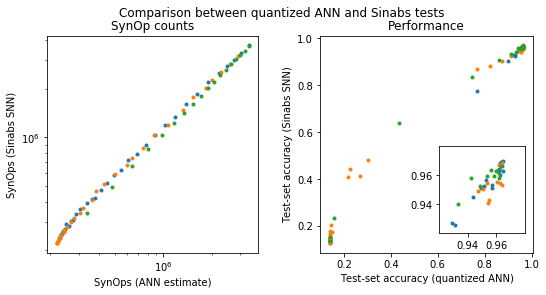

In [212]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.gca().set_aspect('equal')
for i, name in enumerate(coefficients.keys()):  # exclude nopenalty
    if name == 'Baseline': continue
    plt.plot(act_qtrain[name], act_sinabs[name], '.')
plt.xscale('log')
plt.yscale('log')
plt.title('SynOp counts')
plt.xlabel('SynOps (ANN estimate)')
plt.ylabel('SynOps (Sinabs SNN)')

plt.subplot(122)
plt.gca().set_aspect('equal')
axin1 = plt.gca().inset_axes([0.56, 0.09, 0.4, 0.4])
for i, name in enumerate(coefficients.keys()):  # exclude nopenalty
    if name == 'Baseline': continue
    plt.plot(acc_qtrain[name], acc_sinabs[name], '.', c=f'C{i}')
    axin1.plot(acc_qtrain[name], acc_sinabs[name], '.', c=f'C{i}')
axin1.set_xlim([.92, .98])
axin1.set_ylim([.92, .98])
axin1.set_xticks([.94, .96])
axin1.set_yticks([.94, .96])
plt.xlabel('Test-set accuracy (quantized ANN)')
plt.ylabel('Test-set accuracy (Sinabs SNN)')
plt.title('Performance')

# plt.tight_layout()
plt.suptitle("Comparison between quantized ANN and Sinabs tests")

## Showing how the dataset is like

['frame', 'spiketrain', 'label', 'original_filename', 'bins_xy']


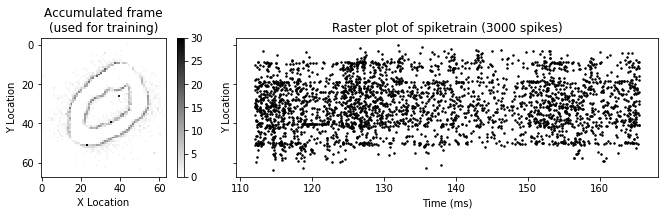

In [17]:
f = np.load('data/train/mnist_0_scale16_0001_0002.npz')

print(list(f.keys()))

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True, gridspec_kw={'width_ratios': [1, 2.]})
im = ax[0].imshow(f['frame'], interpolation='none', cmap=plt.cm.gray_r)

x, y, t = f['spiketrain']['x'], f['spiketrain']['y'], f['spiketrain']['t']
x_loc, y_loc = (x - x.min()) / (x.max()-x.min()), (y - y.min()) / (y.max() - y.min())
loc = x_loc + y_loc

ax[1].plot(t/1000, (1-y_loc)*64, '.k', markersize=3)

ax[0].set_ylabel("Y Location")
ax[1].set_ylabel("Y Location")
ax[1].set_xlabel("Time (ms)")
ax[0].set_xlabel("X Location")
ax[0].set_title("Accumulated frame\n(used for training)")
ax[1].set_title("Raster plot of spiketrain (3000 spikes)")

fig.colorbar(im, ax=ax[0])

fig.tight_layout()
fig.savefig('figures/data-raster.pdf', bbox_inches='tight')

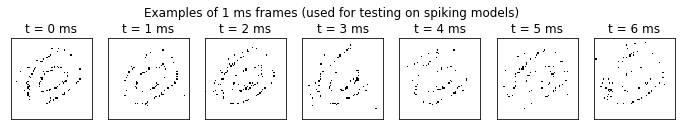

In [8]:
h = np.histogramdd((x, y, t), bins=(*f['bins_xy'], np.arange(t.min(), t.max(), 1000)))[0]

N = 7 

fig, ax = plt.subplots(1, N, figsize=(1.7*N, 2.1))

for i in range(N):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    T = i#53//N*i
    ax[i].set_title(f't = {T} ms')
    ax[i].imshow(h[:, :, T], plt.cm.gray_r, vmin=0, vmax=1)
    
fig.suptitle("Examples of 1 ms frames (used for testing on spiking models)")
fig.savefig('figures/ms-frames.pdf', bbox_inches='tight')